## 通过时间反向传播
当我们⾸次实现循环神经⽹络（8.5节）时，遇到了梯度爆炸的问题。如果做了练习题，就会发现梯度截断对
于确保模型收敛⾄关重要。为了更好地理解此问题，本节将回顾序列模型梯度的计算⽅式，它的⼯作原理没
有什么新概念，毕竟我们使⽤的仍然是链式法则来计算梯度。  

之前描述了多层感知机中的前向与反向传播及相关的计算图。循环神经⽹络中的前向传播相对简
单。通过时间反向传播（backpropagation through time，BPTT）(Werbos, 1990)实际上是循环神经⽹络中反
向传播技术的⼀个特定应⽤。它要求我们将循环神经⽹络的计算图⼀次展开⼀个时间步，以获得模型变量和
参数之间的依赖关系。然后，基于链式法则，应⽤反向传播来计算和存储梯度。由于序列可能相当⻓，因此
依赖关系也可能相当⻓。例如，某个1000个字符的序列，其第⼀个词元可能会对最后位置的词元产⽣重⼤影
响。这在计算上是不可⾏的（它需要的时间和内存都太多了），并且还需要超过1000个矩阵的乘积才能得到
⾮常难以捉摸的梯度。这个过程充满了计算与统计的不确定性。在下⽂中，我们将阐明会发⽣什么以及如何
在实践中解决它们。

## 循环神经网络的梯度分析
我们从⼀个描述循环神经⽹络⼯作原理的简化模型开始，此模型忽略了隐状态的特性及其更新⽅式的细节。
这⾥的数学表⽰没有像过去那样明确地区分标量、向量和矩阵，因为这些细节对于分析并不重要，反⽽只会
使本⼩节中的符号变得混乱。

在这个简化模型中，我们将时间步t的隐状态表⽰为ht，输⼊表⽰为xt，输出表⽰为ot。回想⼀下我们在8.4.2节中
的讨论，输⼊和隐状态可以拼接后与隐藏层中的⼀个权重变量相乘。因此，我们分别使⽤wh和wo来表⽰隐藏
层和输出层的权重。每个时间步的隐状态和输出可以写为：

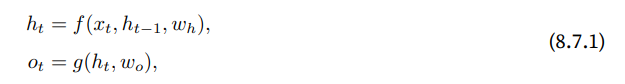

其中f和g分别是隐藏层和输出层的变换。因此，我们有⼀个链 {. . . ,(xt−1, ht−1, ot−1),(xt, ht, ot), . . .}，它们
通过循环计算彼此依赖。前向传播相当简单，⼀次⼀个时间步的遍历三元组(xt, ht, ot)，然后通过⼀个⽬标函
数在所有T个时间步内评估输出ot和对应的标签yt之间的差异：

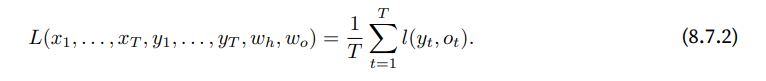

对于反向传播，问题则有点棘⼿，特别是当我们计算⽬标函数L关于参数wh的梯度时。具体来说，按照链式
法则：

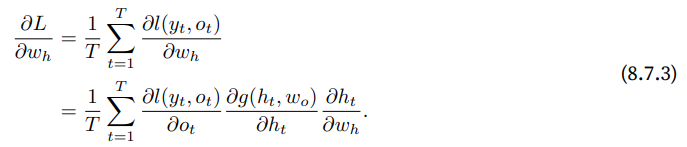

在上式中乘积的第⼀项和第⼆项很容易计算，⽽第三项∂ht/∂wh是使事情变得棘⼿的地⽅，因为我们需要
循环地计算参数wh对ht的影响。根据第一个式子中的递归计算，ht既依赖于ht−1⼜依赖于wh，其中ht−1的计算也
依赖于wh。因此，使⽤链式法则产⽣：  

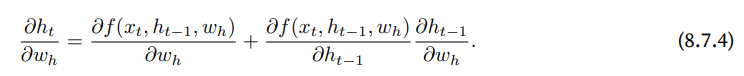

为了导出上述梯度，假设我们有三个序列{at}, {bt}, {ct}，当t = 1, 2, . . .时，序列满⾜a0 = 0且at = bt +ctat−1。
对于t ≥ 1，就很容易得出：  

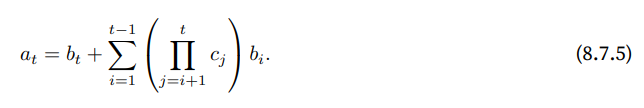  

基于下列公式替换at、bt和ct：  
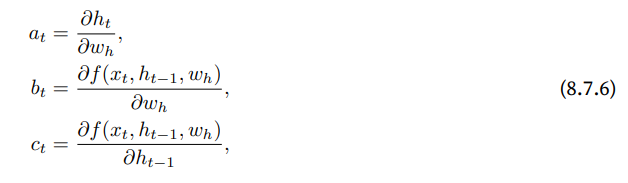

公式 (8.7.4)中的梯度计算满⾜at = bt+ctat−1。因此，对于每个 (8.7.5)，我们可以使⽤下⾯的公式移除 (8.7.4)中
的循环计算

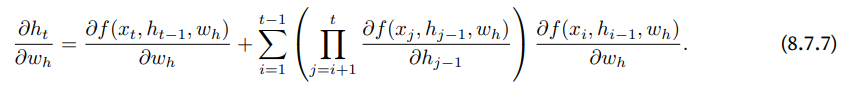 

虽然我们可以使⽤链式法则递归地计算∂ht/∂wh，但当t很⼤时这个链就会变得很⻓。我们需要想想办法来处
理这⼀问题.



### 完全计算
显然，我们可以仅仅计算 (8.7.7)中的全部总和，然⽽，这样的计算⾮常缓慢，并且可能会发⽣梯度爆炸，因
为初始条件的微⼩变化就可能会对结果产⽣巨⼤的影响。也就是说，我们可以观察到类似于蝴蝶效应的现象，
即初始条件的很⼩变化就会导致结果发⽣不成⽐例的变化。这对于我们想要估计的模型⽽⾔是⾮常不可取
的。毕竟，我们正在寻找的是能够很好地泛化⾼稳定性模型的估计器。因此，在实践中，这种⽅法⼏乎从未
使⽤过。

### 截断时间步
或者，我们可以在τ步后截断 (8.7.7)中的求和计算。这是我们到⽬前为⽌⼀直在讨论的内容，例如在 8.5节中
分离梯度时。这会带来真实梯度的近似，只需将求和终⽌为∂ht−τ /∂wh。在实践中，这种⽅式⼯作得很好。它
通常被称为截断的通过时间反向传播 (Jaeger, 2002)。这样做导致该模型主要侧重于短期影响，⽽不是⻓期影
响。这在现实中是可取的，因为它会将估计值偏向更简单和更稳定的模型。

### 随机截断
最后，我们可以⽤⼀个随机变量替换∂ht/∂wh，该随机变量在预期中是正确的，但是会截断序列。这个随机
变量是通过使⽤序列ξt来实现的，序列预定义了0 ≤ πt ≤ 1，其中P(ξt = 0) = 1 − πt且P(ξt = π−1t) = πt，因
此E[ξt] = 1。我们使⽤它来替换 (8.7.4)中的梯度∂ht/∂wh得到：  
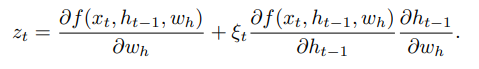

从ξt的定义中推导出来E[zt] = ∂ht/∂wh。每当ξt = 0时，递归计算终⽌在这个t时间步。这导致了不同⻓度序
列的加权和，其中⻓序列出现的很少，所以将适当地加⼤权重。这个想法是由塔莱克和奥利维尔 (Tallec and
Ollivier, 2017)提出的。



### 比较策略
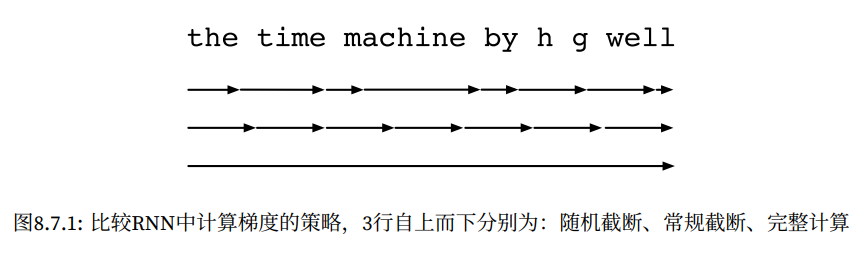  

图8.7.1说明了当基于循环神经⽹络使⽤通过时间反向传播分析《时间机器》书中前⼏个字符的三种策略：
* 第⼀⾏采⽤随机截断，⽅法是将⽂本划分为不同⻓度的⽚断；
* 第⼆⾏采⽤常规截断，⽅法是将⽂本分解为相同⻓度的⼦序列。这也是我们在循环神经⽹络实验中⼀
直在做的；
* 第三⾏采⽤通过时间的完全反向传播，结果是产⽣了在计算上不可⾏的表达式。

遗憾的是，虽然随机截断在理论上具有吸引⼒，但很可能是由于多种因素在实践中并不⽐常规截断更好。⾸
先，在对过去若⼲个时间步经过反向传播后，观测结果⾜以捕获实际的依赖关系。其次，增加的⽅差抵消了
时间步数越多梯度越精确的事实。第三，我们真正想要的是只有短范围交互的模型。因此，模型需要的正是
截断的通过时间反向传播⽅法所具备的轻度正则化效果。


## 小结
* “通过时间反向传播”仅仅适⽤于反向传播在具有隐状态的序列模型。
* 截断是计算⽅便性和数值稳定性的需要。截断包括：规则截断和随机截断。
* 矩阵的⾼次幂可能导致神经⽹络特征值的发散或消失，将以梯度爆炸或梯度消失的形式表现。
* 为了计算的效率，“通过时间反向传播”在计算期间会缓存中间值。
